# Day 4: Data Acquistion and Visualization

## Data Source
* 基本市況報導網站: http://mis.twse.com.tw/stock/index.jsp
* 臺灣期貨交易所即時行情: http://info512.taifex.com.tw/
* 期貨每日交易行情下載: http://www.taifex.com.tw/cht/3/dlFutDailyMarketView
* 選擇權每日交易行情下載: http://www.taifex.com.tw/cht/3/dlOptDailyMarketView
* 神秘金字塔: http://norway.twsthr.info/index.aspx
* 銀行外匯交易.匯率比較.匯率查詢.匯率換算: https://www.taiwanrate.org/
* 臺灣銀行牌告匯率: https://rate.bot.com.tw/xrt?Lang=zh-TW
* MoneyDJ國內基金: https://www.moneydj.com/funddj/ya/YP401002.djhtm
* 臺灣證券交易所除權除息計算結果: http://www.tse.com.tw/zh/page/trading/exchange/TWT49U.html
* 臺灣證券交易所股票減資恢復買賣參考價格: http://www.twse.com.tw/zh/page/trading/exchange/TWTAUU.html
* 臺灣證券交易所上市公司普通股增資除權除息: http://www.tse.com.tw/zh/exchange/TWT49UDetail?STK_NO=1101&&T1=20180726
* 臺灣證券交易所發行量加權股價報酬指數: http://www.twse.com.tw/zh/page/trading/indices/MFI94U.html
* 臺灣證券交易所Data E-Shop: https://eshop.twse.com.tw/en/category/all

(陸續更新)

### TWSE Crawler

#### 1. Set destination folder

In [ ]:
from os import mkdir
from os.path import isdir

dst = "data"
if not isdir(dst):
    print("Destination folder: ./{0} not found...creating ./{0}".format(dst))
    mkdir(dst)
else:
    print("Destination folder: ./{}...ready".format(dst))

#### 2. Access to TWSE by requests
* [urllib.request](https://docs.python.org/3/library/urllib.request.html): extensible library for opening URLs

In [ ]:
import requests
import time

date = [2019, 5, 31]
date_str = '{0}{1:02d}{2:02d}'.format(date[0], date[1], date[2])
url = 'http://www.twse.com.tw/exchangeReport/MI_INDEX'

query_params = {
    'date': date_str,
    'response': 'json',
    'type': 'ALL',
    '_': str(round(time.time() * 1000) - 500)
}

page = requests.get(url, params = query_params)
content = page.json()
print(content)

#### 3. Create functions to clean row data and save to files
* Regular expressions (RE)
    * Tutorial on regular expressions: http://www.cs.fsu.edu/~carnahan/cis4930sp17/Lecture8_cis4930.pdf
    * RE tutorial: https://docs.python.org/3/library/re.html
    * https://regexone.com/ (highly recommended!)

In [ ]:
import re
import csv

def clean_row(row):
    for index, content in enumerate(row):
        row[index] = re.sub(",", "", content.strip()) # clean commas and spaces
    return row

def record(stock_id, row):
    with open('{}/{}.csv'.format(dst, stock_id), 'a') as f:
        cw = csv.writer(f, lineterminator = '\n')
        cw.writerow(row)

#### 4. Save daily trading data for each stock
* For each row in one file, it includes date, share volume, value volume, open price, high price, low price, close price, close-open, number of trades (shown as the listing).

In [ ]:
date_str2 = '{0:04d}/{1:02d}/{2:02d}'.format(date[0], date[1], date[2])

for data in content['data5']:    
    sign = '-' if data[9].find('green') > 0 else ''
    row = clean_row([date_str2,        # 日期
                     data[2],          # 成交股數
                     data[4],          # 成交金額
                     data[5],          # 開盤價
                     data[6],          # 最高價
                     data[7],          # 最低價
                     data[8],          # 收盤價
                     sign + data[10],  # 漲跌價差
                     data[3],          # 成交筆數
    ])
    record(data[0].strip(), row)

#### Exercise: add your stock list
* For example, try this list: https://www.csie.ntu.edu.tw/~d00922011/python/data/stock10.csv

In [ ]:
import csv

def load(filename):
    
    print("Load {}...".format(filename))
    with open(filename, "r") as f:
        reader = csv.reader(f)
        output = []
        for row in reader:
            output.append(row[0])
    return output

In [ ]:
load ("stock10.csv")

#### Complete program
* argparse tutorial: https://docs.python.org/3/howto/argparse.html
* Download [twse_crawl.py](https://www.csie.ntu.edu.tw/~d00922011/python/program/twse_crawl.py) with [stock10.csv](https://www.csie.ntu.edu.tw/~d00922011/python/data/stock10.csv) (adapted from [Taiwan Stock Exchange crawler](https://github.com/Asoul/tsec)).
* To execute twse_crawl.py,
    * Open a terminal (in the environment of Anaconda);
    * Type the following instruction to change to the target folder:
    ```bash
    python twse_crawl.py -d 2019 05 31 -f stock10.csv
    ```
* You may try to crawl OTC data by yourself!

### Another Example: Monthly Sales
* For example, http://mops.twse.com.tw/nas/t21/sii/t21sc03_108_5_0.html.

In [14]:
import pandas as pd
import requests
from io import StringIO
import time

def monthly_report(year, month):
    
    if year > 1990:
        year -= 1911
    
    url = 'http://mops.twse.com.tw/nas/t21/sii/t21sc03_{}_{}.html'.format(year, month)
    if year <= 98:
        url = 'http://mops.twse.com.tw/nas/t21/sii/t21sc03_{}_{}.html'.format(year, month)
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    
    r = requests.get(url, headers=headers)
    r.encoding = 'big5'

    dfs = pd.read_html(StringIO(r.text), encoding = 'big-5')

    df = pd.concat([df for df in dfs if df.shape[1] <= 11 and df.shape[1] > 5])
    
    if 'levels' in dir(df.columns):
        df.columns = df.columns.get_level_values(1)
    else:
        df = df[list(range(0,10))]
        column_index = df.index[(df[0] == '公司代號')][0]
        df.columns = df.iloc[column_index]
    
    df['當月營收'] = pd.to_numeric(df['當月營收'], 'coerce')
    df = df[~df['當月營收'].isnull()]
    df = df[df['公司代號'] != '合計']
    
    time.sleep(5)

    return df

In [15]:
monthly_report(108, 5)

公司代號     公司名稱      當月營收      上月營收    去年當月營收  上月比較增減(%)  去年同月增減(%)  \
0     1101       台泥  10903967  10596314  11539982       2.90      -5.51   
1     1102       亞泥   8435765   8434811   7698165       0.01       9.58   
2     1103       嘉泥    146479    160751    185856      -8.87     -21.18   
3     1104     環球水泥    421251    418992    426170       0.53      -1.15   
4     1108     幸福水泥    305274    323834    294581      -5.73       3.62   
5     1109     信大水泥    800417    753252    625561       6.26      27.95   
6     1110       東泥    132249    118229    142543      11.85      -7.22   
0     1201     味全公司   1809938   1695994   1693716       6.71       6.86   
1     1203     味王公司    531311    469207    526103      13.23       0.98   
2     1210     大成長城   6390612   6424220   6115699      -0.52       4.49   
3     1213       大飲     38938     28570     47299      36.28     -17.67   
4     1215     卜蜂企業   1768590   1739496   1845422       1.67      -4.16   
5     1216       統一  38716214  36918812  37995651       4.86       1.89   
6     1217      愛之味    318595    287677    316505      10.74       0.66   
7     1218     泰山企業    645123    592778    714359       8.83      -9.69   
8     1219     福壽實業   1049658   1038477   1040713       1.07       0.85   
9     1220       台榮    242992    209667    214200      15.89      13.44   
10    1225      福懋油    857478    889193    906043      -3.56      -5.36   
11    1227       佳格   2130222   1776586   1738673      19.90      22.51   
12    1229     聯華實業    729961    616100    443093      18.48      64.74   
13    1231     聯華食品    695419    642774    606265       8.19      14.70   
14    1232      大統益   1406554   1328619   1426938       5.86      -1.42   
15    1233       天仁    191640    165999    195663      15.44      -2.05   
16    1234       黑松    702807    618002    769606      13.72      -8.67   
17    1235       興泰      3028      2555      2691      18.51      12.52   
18    1236     宏亞食品     99992    123213     98968     -18.84       1.03   
19    1256  鮮活果汁-KY    364169    313992    327761      15.98      11.10   
20    1702     南僑投控   1556349   1479700   1578262       5.18      -1.38   
21    1737       臺鹽    260904    228226    340986      14.31     -23.48   
0     1301       台塑  19007532  19209008  22361241      -1.04     -14.99   
..     ...      ...       ...       ...       ...        ...        ...   
43    9902       台火      8099     19883      8665     -59.26      -6.53   
44    9904     寶成工業  28406728  27181998  26347317       4.50       7.81   
45    9905      大華金    724147    653645    662043      10.78       9.38   
46    9907     統一實業   2855861   2566659   3092717      11.26      -7.65   
47    9910     豐泰企業   5819562   5773712   4736888       0.79      22.85   
48    9911     台灣櫻花    493888    452698    422047       9.09      17.02   
49    9914      美利達   2393884   2580055   2820375      -7.21     -15.12   
50    9917       中保   1119731   1095636   1134779       2.19      -1.32   
51    9919      康那香    325781    285506    270933      14.10      20.24   
52    9921     巨大機械   5380719   5780125   5384650      -6.90      -0.07   
53    9924     台灣福興    747629    834254    655813     -10.38      14.00   
54    9925     新光保全    579757    586064    576445      -1.07       0.57   
55    9927       泰銘    839527    771395   1009452       8.83     -16.83   
56    9928       中視     57250     67369     62266     -15.02      -8.05   
57    9929       秋雨     86770     95497     57155      -9.13      51.81   
58    9930     中聯資源    761902    777131    789379      -1.95      -3.48   
59    9933     中鼎工程   4576483   4458911   5203906       2.63     -12.05   
60    9934     成霖企業   1395235   1528779   1559887      -8.73     -10.55   
61    9935      慶豐富    569063    561754    456208       1.30      24.73   
62    9938     台灣百和   1138518   1292121    990147     -11.88      14.98   
63    9939       宏全   2182855   1969196   2013008      10.85       8.43   
64    9940     信義房屋   1062089  

### Other GitHub Projects
* Taiwan Stock Exchange real time crawler: https://github.com/Asoul/tsrtc
* Taiwan Options Exchange crawler: https://github.com/gaga5lala/tw_options_crawler (broken since 2019)
* Taifex qoute python wrapper, calculate implied volatility and visualization: https://github.com/Yvictor/IVtws

## Package: pandas
* Feasible data structures: Series (1D), DataFrame (2D), Panel (3D). We will focus on DataFrame.
* Useful functions of DataFrame: read_csv(), head(), tail(), info(), index, shape, count(), columns, describe(). sort_index(), sort_values(), dropna(), fillna(), pd.concat(), pd.merge(), pct_change()
* Data set: <a href = "https://www.csie.ntu.edu.tw/~d00922011/python/data/twse10.zip">twse10.zip</a>
* Python data analysis library: https://pandas.pydata.org/
    * pandas-datareader: https://pandas-datareader.readthedocs.io/en/latest/
    * pandas cookbook: https://github.com/jvns/pandas-cookbook
    * Cheat sheet: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf
* Refereces:
    * Pythonic data cleaning with numpy and pandas: https://realpython.com/python-data-cleaning-numpy-pandas/
    * Cheat sheets by DataCamp: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Pandas_Cheat_Sheet_2.pdf

In [16]:
import pandas as pd

headers = ["Date", "Share Volume", "Value Volume", "Open", "High", "Low", "Close", "Close-Open", "Trades"]
df = pd.read_csv("./2330.csv", names = headers)
df.sort_values(by = "Date", inplace = True, ascending = True)

# df["Date"] = pd.to_datetime(df.Date)
df.Date = pd.to_datetime(df.Date)

In [17]:
df.set_index("Date", inplace = True)

In [18]:
df.head(10) # you can try tail(N) for the last N rows

Share Volume  Value Volume   Open   High    Low  Close  \
Date                                                                 
2019-01-02      32900482    7276419230  226.5  226.5  219.0  219.5   
2019-01-03      34615620    7459051790  214.0  218.0  214.0  215.5   
2019-01-04      67043521   13987136785  211.5  211.5  206.5  208.0   
2019-01-07      35695176    7591116569  212.0  214.0  211.0  213.0   
2019-01-08      23794481    5019703557  212.0  212.5  210.0  211.0   
2019-01-09      51255446   11006827093  212.0  216.5  211.0  215.5   
2019-01-10      20832593    4491377349  216.0  216.5  214.5  216.0   
2019-01-11      28658288    6296719320  219.0  220.5  218.0  220.5   
2019-01-14      17612296    3844735324  218.5  220.0  217.0  218.5   
2019-01-15      42990923    9399209983  216.5  221.0  215.5  221.0   

            Close-Open  Trades  
Date                            
2019-01-02        -6.0   12329  
2019-01-03        -4.0   14549  
2019-01-04        -7.5   28786  
2019-01-07         5.0   11224  
2019-01-08        -2.0    9377  
2019-01-09         4.5   14098  
2019-01-10         0.5    6018  
2019-01-11         4.5   11198  
2019-01-14        -2.0    6469  
2019-01-15         2.5   11609

In [19]:
df.info() # overview

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2019-01-02 to 2019-06-05
Data columns (total 8 columns):
Share Volume    98 non-null int64
Value Volume    98 non-null int64
Open            98 non-null float64
High            98 non-null float64
Low             98 non-null float64
Close           98 non-null float64
Close-Open      98 non-null float64
Trades          98 non-null int64
dtypes: float64(5), int64(3)
memory usage: 6.9 KB


In [20]:
df.shape

(98, 8)

In [21]:
df.count()

Share Volume    98
Value Volume    98
Open            98
High            98
Low             98
Close           98
Close-Open      98
Trades          98
dtype: int64

In [22]:
df.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17',
               '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-03-04', '2019-03-05',
               '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11',
               '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15',
               '2019-03-18', '2019-03-19', '2019-03-21', '2019-03-22',
               '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28',
               '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03',
      

In [23]:
df.columns

Index(['Share Volume', 'Value Volume', 'Open', 'High', 'Low', 'Close',
       'Close-Open', 'Trades'],
      dtype='object')

In [24]:
df.describe()

Share Volume  Value Volume        Open        High         Low  \
count  9.800000e+01  9.800000e+01   98.000000   98.000000   98.000000   
mean   3.319467e+07  7.901648e+09  239.040816  240.454082  237.132653   
std    1.455036e+07  3.378668e+09   15.359049   15.183260   15.169923   
min    1.388815e+07  3.379511e+09  211.500000  211.500000  206.500000   
25%    2.366292e+07  5.621195e+09  229.125000  230.125000  227.625000   
50%    3.026588e+07  7.165483e+09  237.250000  238.750000  234.250000   
75%    3.782268e+07  9.318475e+09  251.000000  252.750000  249.375000   
max    9.932203e+07  2.291077e+10  270.000000  270.000000  267.500000   

            Close  Close-Open        Trades  
count   98.000000   98.000000     98.000000  
mean   238.811224    0.081633  10683.275510  
std     15.113917    3.374933   4177.882601  
min    208.000000   -8.000000   3948.000000  
25%    229.000000   -2.000000   7997.750000  
50%    236.750000    0.250000  10030.000000  
75%    250.125000    2.500000  12777.250000  
max    269.000000    7.000000  28786.000000

In [25]:
df["Traded Volume per Trade"] = df["Share Volume"] / df["Trades"]
df["Traded Volume per Trade"] = df["Traded Volume per Trade"].apply(round)
df["Traded Volume per Trade"].tail()

Date
2019-05-30    4603
2019-05-31    3422
2019-06-03    4142
2019-06-04    2075
2019-06-05    2417
Name: Traded Volume per Trade, dtype: int64

In [26]:
?df.plot

In [27]:
fig = df[["Open", "High", "Low", "Close"]].plot.line(grid = True)
fig.set_ylabel("Price")

Text(0, 0.5, 'Price')

In [28]:
closes = df.loc[:, ["Close"]]
closes.head(10)

Close
Date             
2019-01-02  219.5
2019-01-03  215.5
2019-01-04  208.0
2019-01-07  213.0
2019-01-08  211.0
2019-01-09  215.5
2019-01-10  216.0
2019-01-11  220.5
2019-01-14  218.5
2019-01-15  221.0

In [29]:
print(closes.max())
print(closes.min())

Close    269.0
dtype: float64
Close    208.0
dtype: float64


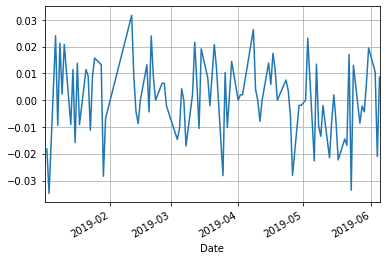

In [30]:
df["Return rate"] = df["Close"].pct_change()
df["Return rate"].head(10)
df["Return rate"].plot.line(grid = True)

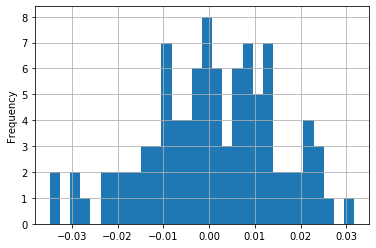

In [31]:
df["Return rate"].plot.hist(bins = 30, grid = True)

#### Exercise: Crawler feat. Pandas

In [57]:
import os
import requests
import pandas as pd
from datetime import datetime

def crawler(date):
    
    try:
        r = requests.get('http://www.tse.com.tw/fund/T86?response=csv&date={}&selectType=ALLBUT0999'.format(date))
    except:
        return None

    try:
        df = pd.read_csv(StringIO(r.text), header = 1).dropna(how = 'all', axis = 1).dropna(how = 'any')
    except:
        return None
    
    df = df.astype(str).apply(lambda s: s.str.replace(',', ''))
    df['stock_id'] = df['證券代號'].str.replace('=', '').str.replace('"', '')
    df['date'] = date
    df = df.set_index(['stock_id', 'date'])
    
    return df.apply(lambda s: pd.to_numeric(s, errors = 'coerce')).dropna(how = 'all', axis = 1)

In [58]:
crawler("20190618")

證券代號  外陸資買進股數(不含外資自營商)  外陸資賣出股數(不含外資自營商)  \
stock_id date                                                   
1605     20190618  1605.0          33108000           3847200   
00637L   20190618     NaN          13220000           1704000   
1101     20190618  1101.0          11375100           2780954   
2834     20190618  2834.0           8367800           2953000   
2890     20190618  2890.0           9397600           4538464   
2887     20190618  2887.0           8348000           3759844   
2892     20190618  2892.0           5805200           2357510   
2633     20190618  2633.0           4509000           1864796   
2324     20190618  2324.0           2705000           1424334   
5876     20190618  5876.0           4030000           1551400   
2377     20190618  2377.0           3194000            792826   
2303     20190618  2303.0          25631000          22877954   
2618     20190618  2618.0           4852400           2140400   
2337     20190618  2337.0           4441000           2182200   
3231     20190618  3231.0           6818093           4398138   
2882     20190618  2882.0           5026236           2850558   
2367     20190618  2367.0           2533000            343000   
2376     20190618  2376.0           2487000            427200   
2888     20190618  2888.0           9430000           7380030   
2845     20190618  2845.0           1395000            346000   
5880     20190618  5880.0           5948000           3861584   
2610     20190618  2610.0           4987200           2861684   
2881     20190618  2881.0           4126000           2317430   
4927     20190618  4927.0           3022000            796000   
2454     20190618  2454.0           3795400           2073693   
00633L   20190618     NaN           2050000             59000   
00655L   20190618     NaN             46000                 0   
00693U   20190618     NaN                 0             25000   
2885     20190618  2885.0           7871552           6492548   
6670     20190618  6670.0           1309173            207000   
...                   ...               ...               ...   
5871     20190618  5871.0            905000           1781950   
2201     20190618  2201.0            510000           1432000   
2823     20190618  2823.0           7605000           8565574   
2456     20190618  2456.0             72000            738000   
3034     20190618  3034.0           2134038           2250762   
1310     20190618  1310.0            172200            220000   
00830    20190618     NaN                 0             86000   
2104     20190618  2104.0            258000           1335000   
2316     20190618  2316.0            217000           1303000   
8163     20190618  8163.0             65000           1152000   
2458     20190618  2458.0            281000           1500800   
2356     20190618  2356.0           1704000           3086000   
2344     20190618  2344.0           2606000           4288000   
8016     20190618  8016.0            412000           1605000   
2323     20190618  2323.0            542000           2492000   
2408     20190618  2408.0           1790163           4011442   
2515     20190618  2515.0            258000           2504000   
3711     20190618  3711.0           3710000           6008256   
00642U   20190618     NaN                 0             20000   
2330     20190618  2330.0          20943000          23691962   
2448     20190618  2448.0            500000           3200928   
6116     20190618  6116.0            706000           4296000   
3017     20190618  3017.0            649000           4093000   
2883     20190618  2883.0           4363000           8774688   
2886     20190618  2886.0          10772000          14772866   
2371     20190618  2371.0          12326000          18436000   
2409     20190618  2409.0           7207321          19367564   
00672L   20190618     NaN              3000           1209000   
3481     20190618  3481.0           7499000          346

#### Exercise
* Target: http://mops.twse.com.tw/mops/web/t163sb04

In [ ]:
import requests
import pandas as pd
import numpy as np

def financial_statement(year, quarter, type = '綜合損益彙總表'):

    if year >= 1000:
        year -= 1911

    if type == '綜合損益彙總表':
        url = 'https://mops.twse.com.tw/mops/web/ajax_t163sb04'
    elif type == '資產負債彙總表':
        url = 'https://mops.twse.com.tw/mops/web/ajax_t163sb05'
    elif type == '營益分析彙總表':
        url = 'https://mops.twse.com.tw/mops/web/ajax_t163sb06'
    else:
        print('type does not match')

    r = requests.post(url, {
        'encodeURIComponent':1,
        'step':1,
        'firstin':1,
        'off':1,
        'TYPEK':'sii',
        'year':str(year),
        'season':str(quarter),
    })

    r.encoding = 'utf8'
    dfs = pd.read_html(r.text, header = None)

    return pd.concat(dfs[1:], axis = 0, sort = False)\
             .set_index("公司代號")\
             .apply(lambda s: pd.to_numeric(s, errors = 'ceorce'))

In [ ]:
df = financial_statement(108, 1, '營益分析彙總表')
df.head()

In [ ]:
df = df.drop(['合計：共 808 家'], axis=1)
df = df.set_index(['公司名稱'])
df = df.astype(float)

In [ ]:
df = df.drop(['合計：共 808 家'], axis=1).set_index(['公司名稱']).astype(float)
df['毛利率(%)(營業毛利)/(營業收入)']

In [ ]:
df.loc['台積電']

In [ ]:
df.loc[['台積電', '聯發科']]

In [ ]:
df.describe()

In [ ]:
df['毛利率(%)(營業毛利 / 營業收入)'].hist(bins=range(-100,100))

In [ ]:
cond1 = df['毛利率(%)(營業毛利)/(營業收入)'].astype(float) > 20
cond2 = df['營業利益率(%)(營業利益)/(營業收入)'].astype(float) > 5

In [ ]:
df[cond1 & cond2]

## Graphics

### Package: Matplotlib
* **Comprehensive** matplotlib tutorial: http://www.labri.fr/perso/nrougier/teaching/matplotlib/ by Nicolas P. Rougier
* References
    * https://matplotlib.org/contents.html
    * [05_Visualization.ipynb](https://github.com/yhilpisch/py4fi/blob/master/jupyter36/05_Visualization.ipynb) by py4fi
    * http://scipy-lectures.org/intro/matplotlib/index.html
    * Cheat sheets by DataCamp: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Matplotlib_Cheat_Sheet.pdf

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 4))
plt.subplot(211)
plt.title("2330")
plt.plot(df.index, df["Close"], "o", linewidth = 0.5, linestyle = "--", markersize = 8)
plt.grid(True)
plt.ylabel("Close Price")

plt.subplot(212)
plt.bar(df.index, df["Share Volume"], color = "r")
plt.grid(True)
plt.ylabel("Share Volume")

plt.savefig("2330.png", dpi = 150) # this line should be placed before show()
plt.show()

### Package: Seaborn & mpl_finance
* Official seaborn tutorial: https://seaborn.pydata.org/tutorial.html
* Financial plots:
    * [mpl_finance](https://github.com/matplotlib/mpl_finance)
    * To install mpl_finance, type the following instruction in the terminal:

        ```python
        pip install mpl_finance
        ```

    * Read the document of [matplotlib.finance](https://matplotlib.org/api/finance_api.html).
    * Try [mpl_finance_demo.py](https://www.csie.ntu.edu.tw/~d00922011/python/program/mpl_finance_demo.py).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = np.random.random([100, 2])
plt.scatter(data[:, 0], data[:, 1])
sns.set(style = "darkgrid")
plt.axis("square")
plt.show()

In [ ]:
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

stock = "AAPL"
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime.today()

f = pdr.get_data_yahoo(stock, start = start_date, end = end_date)

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)

sns.set(style = "white")

f.reset_index(inplace = True)
del f["Adj Close"]
del f["Volume"]
f.Date = mdates.date2num(f.Date)
f = f[["Date", "Open", "High", "Low", "Close"]]
quotes = f.values.tolist()

candlestick_ohlc(ax1, quotes, colorup = "r", colordown = "g")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m/%d"))
ax1.grid()
ax1.set_ylabel("Price")

plt.title(stock)
plt.show()

### Technical Analysis
* [Technical Analysis Library in Python](https://github.com/bukosabino/ta)
    * Type the following instruction to install ta in the terminal::
    
    ```python
    pip install ta
    ```
    * Another example: https://github.com/bukosabino/ta/blob/master/examples_to_use/visualize_features.ipynb
    * RTFM: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
* References:
    * List of technical indicators: https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/list-of-technical-indicators/
    * Basics of technical analysis: https://www.bernstein-bank.com/wp-content/uploads/2016/08/Technical-Analysis-Englisch.pdf by Bernstein Bank

In [ ]:
import pandas as pd

headers = ["Date", "Share Volume", "Value Volume", "Open Price", "High Price", "Low Price", "Close Price", "Return", "Trades"]
df = pd.read_csv("./2330.csv", names = headers)
df['Date'] =pd.to_datetime(df.Date)
df.sort_values(by = "Date", inplace = True, ascending = True)
df.set_index("Date", inplace = True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import ta

sns.set(style = "white")
plt.figure(figsize = (12, 8))

df['Bollinger Hband'] = ta.bollinger_hband(df["Close Price"])
df['Bollinger Mavg'] = ta.bollinger_mavg(df["Close Price"])
df['Bollinger Lband'] = ta.bollinger_lband(df["Close Price"])

df['Close Price'].plot.line(marker = "o")
df['Bollinger Hband'].plot.line(linestyle = "--")
df['Bollinger Mavg'].plot.line(linestyle = "--")
df['Bollinger Lband'].plot.line(linestyle = "--")
plt.legend()
plt.grid()
plt.ylabel("Price")
plt.title("2330")

### Package: PyGal